# Tutorial 1A

The first lab tutorial presents the findings and uses part of the experimental methodology from the [original Federated Learning](https://arxiv.org/pdf/1602.05629.pdf) paper. In horizontal federated learning, all clients have access to the same complete model architecture, which they train on local data, sharing information about model updates but not their data.

Before starting, make sure to follow the overall setup for the labs.

---

Before anything else, we download, load, and preprocess the [MNIST dataset](https://archive.ics.uci.edu/dataset/683/mnist+database+of+handwritten+digits), which we will use for all experiments.

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_path = "./data"
ETA = "\N{GREEK SMALL LETTER ETA}"

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

torch.backends.cudnn.deterministic = True

transform = transforms.Compose([
    transforms.ToTensor(),
    # normalize by training set mean and standard deviation
    # resulting data has mean=0 and std=1
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(data_path, train=True, download=True, transform=transform)
test_loader = DataLoader(
    datasets.MNIST(data_path, train=False, download=False, transform=transform),
    # decrease batch size if running into memory issues when testing
    # a bespoke generator is passed to avoid reproducibility issues
    shuffle=False, drop_last=False, batch_size=10000, generator=torch.Generator())

We can then define a small convolutional neural network that will serve as our model.

In [2]:
import torch.nn as nn
import torch.nn.functional as F


class MnistCnn(nn.Module):
    def __init__(self):
        super(MnistCnn, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)

        return output

With that, we can define a helper method, which, given a model, a loader for iterating through a set of data, and an optimizer for updating the model trains one epoch (i.e., learns going through all the available data once).

In [3]:
from torch.optim import Optimizer


def train_epoch(model: torch.nn.Module, loader: DataLoader, optimizer: Optimizer) -> None:
    model.train()
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

We also define another utility method that splits the whole dataset into the requested number of chunks, picking samples within chunks in a (non-)IID (independent and identically distributed) fashion.

In [5]:
from typing import cast

import numpy as np
import numpy.random as npr
from torch.utils.data import Subset

# started recording, explain with gpt
def split(nr_clients: int, iid: bool, seed: int) -> list[Subset]:
    # TODO
    rng = npr.default_rng(seed)

    if iid:
        splits = np.array_split(rng.permutation(len(train_dataset)), nr_clients)
    else:
        sorted_indices = np.argsort(np.array([target for _data, target in train_dataset]))
        shards = np.array_split(sorted_indices, 2 * nr_clients)
        shuffled_shard_indices = rng.permutation(len(shards))
        splits = [
            np.concatenate([shards[i] for i in inds], dtype=np.int64)
            for inds in shuffled_shard_indices.reshape(-1, 2)]

    return [Subset(train_dataset, split) for split in cast(list[list[int]], splits)]


In [7]:
sample_split = split(100, True, 42)

We define a short class for holding the results of training runs and the parameters used.

In [8]:
from dataclasses import asdict, dataclass, field

from pandas import DataFrame


@dataclass
class RunResult:
    algorithm: str
    n: int  # number of clients
    c: float  # client_fraction
    b: int  # take -1 as inf batchsize
    e: int  # nr_local_epochs
    lr: float  # printed as lowercase eta learningrate
    seed: int
    wall_time: list[float] = field(default_factory=list) #runtime simulated
    message_count: list[int] = field(default_factory=list)
    test_accuracy: list[float] = field(default_factory=list)

    def as_df(self, skip_wtime=True) -> DataFrame:
        self_dict = {
            k.capitalize().replace("_", " "): v
            for k, v in asdict(self).items()}

        if self_dict["B"] == -1:
            self_dict["B"] = "\N{INFINITY}"

        df = DataFrame({"Round": range(1, len(self.wall_time) + 1), **self_dict})
        df = df.rename(columns={"Lr": ETA})
        if skip_wtime:
            df = df.drop(columns=["Wall time"])
        return df

We create an abstract class as a template for all distributed learning clients, defining a method for outputting an update after training a given model on local data.

In [9]:
from abc import ABC, abstractmethod


class Client(ABC): #abstract
    def __init__(self, client_data: Subset, batch_size: int) -> None:
        self.model = MnistCnn().to(device)
        self.generator = torch.Generator()
        self.loader_train = DataLoader(
            client_data, batch_size=batch_size, shuffle=True,
            drop_last=False, generator=self.generator)


    @abstractmethod
    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        ...

On the flip side, a server needs to be able to run the (distributed) training process for a given number of rounds and test the current model it possesses.

In [10]:
class Server(ABC):
    def __init__(self, lr: float, batch_size: int, seed: int) -> None:
        self.clients: list[Client]
        self.lr = lr
        self.batch_size = batch_size
        self.seed = seed
        torch.manual_seed(seed)
        self.model = MnistCnn().to(device)


    @abstractmethod
    def run(self, nr_rounds: int) -> RunResult:
        ...


    def test(self) -> float:
        correct = 0
        self.model.eval()

        with torch.no_grad(): #Accuracy calculation
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = self.model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        return 100. * correct / len(cast(datasets.MNIST, test_loader.dataset))


Over the previously defined server template, we can even formulate a centralized variant, which does not involve clients, as a precursor to distributed versions.

In [11]:
from time import perf_counter

from torch.optim import SGD
from tqdm import tqdm


class CentralizedServer(Server):
    def __init__(self, lr: float, batch_size: int, seed: int) -> None:
        super().__init__(lr, batch_size, seed)
        self.optimizer = SGD(params=self.model.parameters(), lr=lr)
        self.generator = torch.Generator()
        self.loader_train = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True,
            drop_last=False, generator=self.generator)
        self.clients = []

    def run(self, nr_rounds: int) -> RunResult:
        elapsed_time = 0.
        run_result = RunResult("Centralized", 1, 1, self.batch_size, 1, self.lr, self.seed)

        for epoch in tqdm(range(nr_rounds), desc="Epochs", leave=False):
            start_time = perf_counter()
            self.generator.manual_seed(self.seed + epoch + 1)
            train_epoch(self.model, self.loader_train, self.optimizer)
            elapsed_time += perf_counter() - start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(0)
            run_result.test_accuracy.append(self.test())

        return run_result

In [12]:
centralized_server = CentralizedServer(0.5, 1024, 42)
result_centralized = centralized_server.run(5)
centralized_df = result_centralized.as_df()
centralized_df

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,Centralized,1,1,1024,1,0.5,42,0,94.55
1,2,Centralized,1,1,1024,1,0.5,42,0,95.98
2,3,Centralized,1,1,1024,1,0.5,42,0,98.17
3,4,Centralized,1,1,1024,1,0.5,42,0,97.99
4,5,Centralized,1,1,1024,1,0.5,42,0,98.45


We can extend the template with some setup steps common to all decentralized algorithms.

In [15]:
class DecentralizedServer(Server):
    def __init__(
            self, lr: float, batch_size: int, client_subsets: list[Subset],
            client_fraction: float, seed: int) -> None:
        super().__init__(lr, batch_size, seed)
        self.nr_clients = len(client_subsets)
        self.client_fraction = client_fraction
        self.client_sample_counts = [len(subset) for subset in client_subsets]
        self.nr_clients_per_round = max(1, round(client_fraction * self.nr_clients))
        self.rng = npr.default_rng(seed)

The two federated learning algorithms from the paper follow, alongside an overview of metric plotting.

---

For the FedSGD algorithm, the baseline from the paper, we first need to define the client, and we choose to pass gradients from the client as the update result.

In [16]:
class GradientClient(Client):
    def __init__(self, client_data: Subset) -> None:
        super().__init__(client_data, len(client_data))

    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        with torch.no_grad():
            for client_values, server_values in zip(self.model.parameters(), weights):
                client_values[:] = server_values
                client_values.grad = None

        # seeding is not strictly necessary here
        self.generator.manual_seed(seed)
        self.model.train()

        # this will always have one iteratioon
        for data, target in self.loader_train:
            data, target = data.to(device), target.to(device)
            output = self.model(data)
            loss = F.nll_loss(output, target)
            loss.backward()

        return [
            cast(torch.Tensor, x.grad).detach().cpu().clone()
            for x in self.model.parameters()]

We then define the corresponding server.

In [17]:
class FedSgdGradientServer(DecentralizedServer):
    def __init__(
            self, lr: float,
            client_subsets: list[Subset], client_fraction: float, seed: int) -> None:
        super().__init__(lr, -1, client_subsets, client_fraction, seed)
        self.optimizer = SGD(params=self.model.parameters(), lr=lr)
        self.clients = [GradientClient(subset) for subset in client_subsets]

    def run(self, nr_rounds: int) -> RunResult:
        elapsed_time = 0.
        run_result = RunResult(
            "FedSGDGradient", self.nr_clients, self.client_fraction, -1, 1, self.lr, self.seed)

        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            self.optimizer.zero_grad()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(
                self.nr_clients, self.nr_clients_per_round, replace=False)
            chosen_sum_nr_samples = sum(
                self.client_sample_counts[i] for i in indices_chosen_clients)
            chosen_adjusted_gradients: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.

            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                client_gradients = self.clients[ind].update(weights, client_round_seed)
                chosen_adjusted_gradients.append([
                    self.client_sample_counts[ind] / chosen_sum_nr_samples * tens
                     for tens in client_gradients])
                update_time = max(update_time, perf_counter() - update_start_time)

            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            averaged_chosen_gradients: list[torch.Tensor] = [
                torch.stack(x, dim=0).sum(dim=0) for x in zip(*chosen_adjusted_gradients)]

            with torch.no_grad():
                zip_gradient_parameter = zip(averaged_chosen_gradients, self.model.parameters())
                for client_gradient, server_parameter in zip_gradient_parameter:
                    server_parameter.grad = client_gradient.to(device=device)

            self.optimizer.step()
            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(2 * (nr_round + 1) * self.nr_clients_per_round)
            run_result.test_accuracy.append(self.test())

        return run_result


In [19]:
fedsgd_gradient_server = FedSgdGradientServer(0.02, sample_split, 0.2, 42)
result_fedsgd_gradient = fedsgd_gradient_server.run(10)
fedsgd_gradient_df = result_fedsgd_gradient.as_df()
fedsgd_gradient_df

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedSGDGradient,100,0.2,∞,1,0.02,42,40,8.91
1,2,FedSGDGradient,100,0.2,∞,1,0.02,42,80,9.56
2,3,FedSGDGradient,100,0.2,∞,1,0.02,42,120,10.24
3,4,FedSGDGradient,100,0.2,∞,1,0.02,42,160,12.26
4,5,FedSGDGradient,100,0.2,∞,1,0.02,42,200,16.45
5,6,FedSGDGradient,100,0.2,∞,1,0.02,42,240,20.61
6,7,FedSGDGradient,100,0.2,∞,1,0.02,42,280,26.21
7,8,FedSGDGradient,100,0.2,∞,1,0.02,42,320,34.53
8,9,FedSGDGradient,100,0.2,∞,1,0.02,42,360,42.27
9,10,FedSGDGradient,100,0.2,∞,1,0.02,42,400,46.60


The FedAvg algorithm is the paper's main contribution, requiring a client that passes around weights instead of gradients.

In [21]:
class WeightClient(Client):
    def __init__(self, client_data: Subset, lr: float, batch_size: int, nr_epochs: int) -> None:
        super().__init__(client_data, batch_size)
        self.optimizer = SGD(params=self.model.parameters(), lr=lr)
        self.nr_epochs = nr_epochs


    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        with torch.no_grad():
            for client_values, server_values in zip(self.model.parameters(), weights):
                client_values[:] = server_values

        self.generator.manual_seed(seed)

        for _epoch in range(self.nr_epochs):
            train_epoch(self.model, self.loader_train, self.optimizer)

        return [x.detach().cpu().clone() for x in self.model.parameters()]

Following that, we define the actual server code for the method.

In [22]:
class FedAvgServer(DecentralizedServer):
    def __init__(
            self, lr: float, batch_size: int, client_subsets: list[Subset],
            client_fraction: float, nr_local_epochs: int, seed: int) -> None:
        super().__init__(lr, batch_size, client_subsets, client_fraction, seed)
        self.name = "FedAvg"
        self.nr_local_epochs = nr_local_epochs
        self.clients = [
            WeightClient(subset, lr, batch_size, nr_local_epochs)
            for subset in client_subsets]

    def run(self, nr_rounds: int) -> RunResult:
        elapsed_time = 0.
        run_result = RunResult(
            self.name, self.nr_clients, self.client_fraction, self.batch_size,
            self.nr_local_epochs, self.lr, self.seed)

        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(
                self.nr_clients, self.nr_clients_per_round, replace=False)
            chosen_sum_nr_samples = sum(
                self.client_sample_counts[i] for i in indices_chosen_clients)
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.

            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                client_weights = self.clients[ind].update(weights, client_round_seed)
                chosen_adjusted_weights.append([
                    self.client_sample_counts[ind] / chosen_sum_nr_samples * tens
                     for tens in client_weights])
                update_time = max(update_time, perf_counter() - update_start_time)

            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            averaged_chosen_weights: list[torch.Tensor] = [
                torch.stack(x, dim=0).sum(dim=0) for x in zip(*chosen_adjusted_weights)]

            with torch.no_grad():
                zip_weight_parameter = zip(averaged_chosen_weights, self.model.parameters())
                for client_weight, server_parameter in zip_weight_parameter:
                    server_parameter[:] = client_weight.to(device=device)

            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(2 * (nr_round + 1) * self.nr_clients_per_round)
            run_result.test_accuracy.append(self.test())

        return run_result

In [23]:
fedavg_server = FedAvgServer(0.02, 200, sample_split, 0.2, 2, 42)
result_fedavg = fedavg_server.run(10)
fedavg_df = result_fedavg.as_df()
fedavg_df

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,100,0.2,200,2,0.02,42,40,21.94
1,2,FedAvg,100,0.2,200,2,0.02,42,80,53.09
2,3,FedAvg,100,0.2,200,2,0.02,42,120,66.96
3,4,FedAvg,100,0.2,200,2,0.02,42,160,74.70
4,5,FedAvg,100,0.2,200,2,0.02,42,200,77.16
5,6,FedAvg,100,0.2,200,2,0.02,42,240,81.13
6,7,FedAvg,100,0.2,200,2,0.02,42,280,82.74
7,8,FedAvg,100,0.2,200,2,0.02,42,320,84.21
8,9,FedAvg,100,0.2,200,2,0.02,42,360,85.53
9,10,FedAvg,100,0.2,200,2,0.02,42,400,87.30


Finally, we look at a quick example of plotting the accuracy per round of the two algorithms.

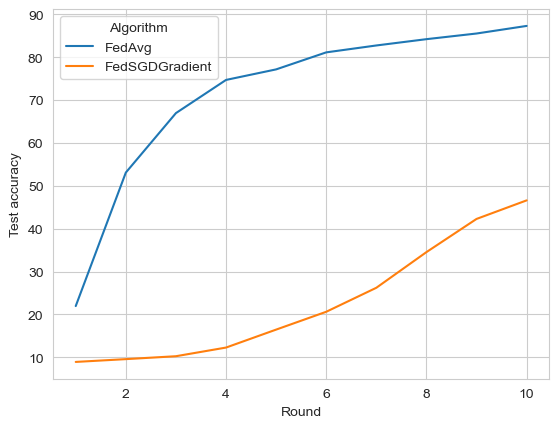

In [25]:
import pandas as pd
import seaborn as sns

df = pd.concat([fedavg_df, fedsgd_gradient_df], ignore_index=True)
ax = sns.lineplot(df, x="Round", y="Test accuracy", hue="Algorithm", seed=0)
_ = ax.set_xticks(df["Round"].unique())